In [47]:
import torch
from torch import nn
import torchvision
import pandas as pd
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
import numpy as np
import ssl
import seaborn as sns
import time
from MaSS import MaSS
import torchbearer

sns.set_theme()
ssl._create_default_https_context = ssl._create_unverified_context

In [48]:
# Device configuration
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [49]:
# Hyper-parameters
num_epochs = 150
batch_size = 64
learning_rate = 0.005

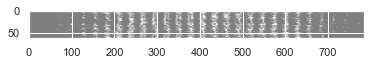

In [50]:
# dataset has PILImage images of range [0, 1].
# We transform them to Tensors of normalized range [-1, 1]
'''
transform = transforms.Compose(
    [transforms.ToTensor(),
     transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])
'''
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Lambda(lambda x: x.view(-1)),
])

train_dataset = torchvision.datasets.MNIST(root='./data', train=True,
                                        download=True, transform=transform)

test_dataset = torchvision.datasets.MNIST(root='./data', train=False,
                                       download=True, transform=transform)

train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size,
                                          shuffle=True)

test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=batch_size,
                                         shuffle=False)

def imshow(img):
    img = img / 2 + 0.5  # unnormalize
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()


# get some random training images
dataiter = iter(train_loader)
images, labels = dataiter.next()

# show images
imshow(torchvision.utils.make_grid(images))

In [51]:
class FCNClass(nn.Module):
    def __init__(self):
        # input: 784 Dimensional Vectors as input
        super(FCNClass, self).__init__()

        # layer 1 (784-100)
        # Hidden Layer
        # Dropout Layer with keep prob 0.5
        self.hidden1 = nn.Sequential(
                        nn.Linear(784, 100),
                        nn.ReLU(),
                        nn.Dropout(p=0.5)
        )

        # Layer 2 (100-100)
        # Hidden Layer
        # Dropout Layer with keep prob 0.5
        self.hidden2 = nn.Sequential(
                        nn.Linear(100, 100),
                        nn.ReLU(),
                        nn.Dropout(p=0.5)
        )

        # Layer 3 (100-100)
        # Hidden Layer
        # Dropout Layer with keep prob 0.5
        self.hidden3 = nn.Sequential(
                        nn.Linear(100, 100),
                        nn.ReLU(),
                        nn.Dropout(p=0.5)
        )

        # Layer 4 (100-10)
        # Hidden Layer
        # Dropout Layer with keep prob 0.5
        self.output = nn.Sequential(
                        nn.Linear(100, 10),
                        nn.ReLU(),
                        nn.Dropout(p=0.5)
        )
        # 10 softmax activated output neurons
        self.outputLayer = nn.Softmax(dim=1)


    def forward(self, x):
        midLevel = self.hidden1(x)
        midLevel = self.hidden2(midLevel)
        midLevel = self.hidden3(midLevel)
        output   = self.output(midLevel)
        return output


In [52]:
model = FCNClass().to(device)

criterion = nn.CrossEntropyLoss()
optimizer = MaSS(model.parameters(), lr=learning_rate, alpha=0.05, kappa_t=3)
opt = "MaSS"

In [53]:
epochs = []
n_total_steps = len(train_loader)
train_loss_average = torch.zeros(num_epochs)
valid_loss_average = torch.zeros(num_epochs)
train_accuracy = torch.zeros(num_epochs)
valid_accuracy = torch.zeros(num_epochs)
scheduler = torch.optim.lr_scheduler.MultiStepLR(optimizer, milestones=[60,120], gamma=0.1)


In [54]:

def train():

    model.train()
    running_train_loss = 0
    correct = 0
    total = 0

    for i, (images, labels) in enumerate(train_loader):
        images = images.to(device)
        labels = labels.to(device)

        # Forward pass
        outputs = model(images)
        train_step_loss = criterion(outputs, labels)

        # Backward and optimize
        optimizer.zero_grad()
        train_step_loss.backward()
        optimizer.step()

        running_train_loss += train_step_loss.item()

        #predictions
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

    accuracy = 100.*correct/total

    #get the training losses and accuracies
    train_loss_average[epoch] = running_train_loss/len(train_loader)
    train_accuracy[epoch] = accuracy

    print(f'Training Loss: {running_train_loss/len(train_loader)}\t \
            Training accuracy: {train_accuracy[epoch]}')


In [55]:
def test():
    model.eval()

    running_valid_loss = 0
    correct = 0
    total = 0

    #validation loop
    with torch.no_grad():
        for i, (images, labels) in enumerate(test_loader):
            images = images.to(device)
            labels = labels.to(device)

            outputs = model(images)
            valid_step_loss = criterion(outputs, labels)

            running_valid_loss += valid_step_loss.item()

            #predictions
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

    accuracy = 100.*correct/total

    #get the validation losses
    valid_loss_average[epoch] = running_valid_loss/len(test_loader)
    valid_accuracy[epoch] = accuracy


    print(f'Validation Loss: {running_valid_loss/len(test_loader)}\t \
            Validation accuracy: {valid_accuracy[epoch]}\t \
            LR:{curr_lr}')

In [56]:
start_time = time.time()
for epoch in range(num_epochs):
    print(f'Epoch: {epoch+1}')

    #get the current learning rate
    curr_lr = optimizer.param_groups[0]['lr']

    train()
    test()

    epochs.append(epoch)



    #step the learning rate scheduler
    scheduler.step()


print("--- %s seconds ---" % (time.time() - start_time))
print('Finished Training')


Epoch: 1
Training Loss: 2.2931436686627644	             Training accuracy: 13.324999809265137
Validation Loss: 2.2516074772853	             Validation accuracy: 39.900001525878906	             LR:0.005
Epoch: 2
Training Loss: 2.2006224034183317	             Training accuracy: 20.8700008392334
Validation Loss: 2.011707569383512	             Validation accuracy: 52.849998474121094	             LR:0.005
Epoch: 3
Training Loss: 2.0725866591752466	             Training accuracy: 26.979999542236328
Validation Loss: 1.7727644694079259	             Validation accuracy: 58.84000015258789	             LR:0.005
Epoch: 4
Training Loss: 1.9383024636870507	             Training accuracy: 32.67333221435547
Validation Loss: 1.5260147866170117	             Validation accuracy: 67.7699966430664	             LR:0.005
Epoch: 5
Training Loss: 1.8362291812388374	             Training accuracy: 35.698333740234375
Validation Loss: 1.3446311821603472	             Validation accuracy: 69.8499984741211	         

KeyboardInterrupt: 

In [ ]:
with torch.no_grad():
    n_correct = 0
    n_samples = 0
    for images, labels in test_loader:
        images = images.reshape(-1, 28*28).to(device)
        labels = labels.to(device)
        outputs = model(images)
        # max returns (value ,index)
        _, predicted = torch.max(outputs.data, 1)
        n_samples += labels.size(0)
        n_correct += (predicted == labels).sum().item()

    acc = 100.0 * n_correct / n_samples
    print(f'Accuracy of the network on the 10000 test images: {acc} %')



In [ ]:
def plotLosses(epochs, Loss, title):
    plt.figure(figsize=(10,6))
    plt.title(title)
    plt.plot(epochs, Loss, label = "Loss")
    plt.legend()
    plt.xlabel("Epochs")
    plt.ylabel("Loss")
    plt.savefig(title + '.png')

In [ ]:
#plot the loss diagrams
plotLosses(epochs, train_loss_average, f'FCN-{opt}_train_loss lr:{learning_rate} acc:{acc}')
plotLosses(epochs, valid_loss_average, f'FCN-{opt}_valid_loss lr:{learning_rate} acc:{acc}')

#plot combo loss diagrams
plt.figure(figsize=(10,6))
plt.title(f'FCN-{opt} lr:{learning_rate} acc:{acc}')
plt.plot(epochs, train_loss_average, label = "Training loss")
plt.plot(epochs, valid_loss_average, label = 'Validation loss')
plt.legend()
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.savefig(f'FCN-Loss-{opt} lr:{learning_rate} acc:{acc}.png')

#plot validation accuracies
plt.figure(figsize=(10,6))
plt.title(f'FCN-{opt} lr:{learning_rate} acc:{acc}')
plt.plot(epochs, train_accuracy, label = "Training accuracy")
plt.plot(epochs, valid_accuracy, label = 'Validation accuracy')
plt.legend()
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.savefig(f'FCN-Accuracy-{opt} lr:{learning_rate} acc:{acc}.png')

PATH = f'./FCN-{opt}-lr:{learning_rate}-acc:{acc}.pth'
torch.save(model.state_dict(), PATH)